# solving dispertion function
before adding annother gaz, we want to find out the theoritical value

### define physical parameters

* `lDe` = $\lambda_{De} = \sqrt{\epsilon _0 T_e/(e n_e)} $    the debye lenth

* `cs` = $c_s = \sqrt{e T_e/(M_i)}$     the ion sound speed
* `Vte` = $V_{Te} = \sqrt{2 e T_e/(m_e)}$     the electron thermal velocity
* `Vti` = $V_{Ti} = \sqrt{2 e T_i/(M_i)}$    the ion thermal velocity


### Dispertion relation

$ 0 = 1 - F(Z'(\omega, k_x)) $


In [1]:
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
from astropy.constants import (e, eps0, m_e, m_p)
from astropy.units import (Volt, m, s)
from scipy.special import erf

from ipywidgets import FloatProgress
from IPython.display import display

%matplotlib inline

# physical values
m1 = 131 * m_p  # proton mass
e = e.si

In [2]:
ne = 1e17 * m**(-3)  # part/m³
Te = 5 * Volt
Ti = Te / 20

lDe = np.sqrt(eps0 * Te / (e * ne)).si
cs = np.sqrt(e * Te / m1).si
Vte = np.sqrt(2 * e * Te / m_e).si
Vti1 = np.sqrt(2 * e * Ti / m1).si
Vde = 5e5 * m / s
wpi = np.sqrt(e**2 * ne / (eps0 * m1)).si

## Define functions

In [3]:
def Z(x):
    x = x.value
    Z = 1j * np.sqrt(np.pi) * np.exp(-x**2) * (1 - erf(- 1j * x))
    return Z


def Zprim(x):
    Zprim = -2 * (1 + x * Z(x))
    return Zprim


def dispfun(kx, w):
    wc = w[0] + w[1] * 1j
    wc = wc / s
    f = 1 - 1 / (2 * kx**2 * lDe**2) * (Zprim((wc - kx * Vde) / (kx * Vte)) +
                                        Te / Ti * Zprim((wc) / (kx * Vti1)))

    return [f.real, f.imag]


def f(w):
    return dispfun(kinp, w)


def wraprox(kx):
    wr = kx * cs / (np.sqrt(1 + kx**2 * lDe**2))
    return wr


def gamaprox(kx):

    g = - np.sqrt(np.pi / 8) * kx * cs / (1 + kx**2 * lDe**2)**2 * (
        (Te / Ti)**(3 / 2) * np.exp(-Te / (2 * Ti) * 1 / (1 + kx**2 * lDe**2))
        + np.sqrt(m_e / m1) * (1 - Vde / cs * np.sqrt(1 + kx**2 * lDe**2)))
    return g

## Validate Solver and compare Xe to H

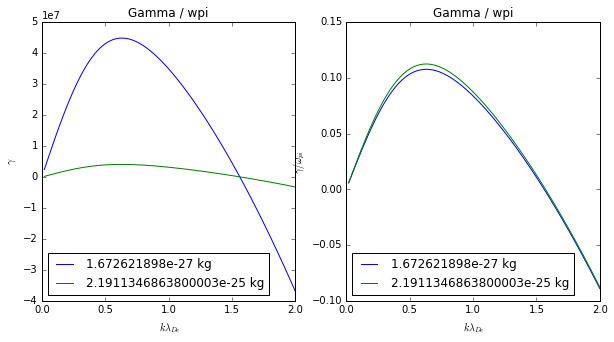

In [25]:
Nbins = 100
kmax = 2

plt.figure(figsize=(10, 5))

maxg = -9999

progress = FloatProgress(min=0, max=2*Nbins)
display(progress)
    
# loop over Mi and Kx to plot the graphs
for m1 in [1 * m_p, 131 * m_p]:
    cs = np.sqrt(e * Te / m1)
    Vti1 = np.sqrt(2 * e * Ti / m1)
    wpi = np.sqrt(e**2 * ne / (eps0 * m1))

    vect_val = []
    vect_ind = []

    for i in np.arange(Nbins):

        index = kmax * (i + 1) / Nbins
        kinp = index / lDe
        # print(kinp)

        vect_ind.append(index)
        #vect_val.append(gamaprox(kinp).value)

        # print(wraprox(kinp),gamaprox(kinp))

        w = fsolve(f,[wraprox(kinp).value,gamaprox(kinp).value])
        vect_val.append(w[1])
        #plt.scatter(index,w[1]/wpi, marker = '+')
        #maxg = max(maxg,w[1]/wpi)
        
        progress.value += 1 # signal to increment the progress bar

    plt.subplot(121)
    plt.plot(vect_ind, vect_val, label=str(m1))

    plt.subplot(122)
    plt.plot(vect_ind, vect_val / wpi, label=str(m1))

# plot all
if True:

    plt.subplot(121)
    plt.xlim(0, 2)
    plt.title("Gamma / wpi")
    # plt.ylim(-0.2,0.2)

    plt.xlabel(" $k\lambda_{De}$")
    plt.ylabel("$\gamma$")
    plt.legend(loc='best')

    plt.subplot(122)
    plt.title("Gamma / wpi")
    plt.xlim(0, 2)
    # plt.ylim(-0.2,0.2)

    plt.xlabel(" $k\lambda_{De}$")
    plt.ylabel("$\gamma/\omega_{pi}$")
    plt.legend(loc='best')

## Xe/H ratio effect on the maximum groth rate

In [7]:
Nbins = 50
Nperc = 50
kmax = 1
percmax = 0.6

m2 = 2 * m_p
m1 = 131 * m_p

Vti2 = np.sqrt(2 * e * Ti / m2).si

# redefine dispertion relation to add 2nd ions
#*******************************************************************
def dispfun(kx, w):
    wc = w[0] + w[1] * 1j
    wc /= s
    f = 1 - 1 / (2 * kx**2 * lDe**2) * (Zprim((wc - kx * Vde) / (kx * Vte)) +
                                        Te / Ti * ratio / (1 + ratio) * Zprim((wc) / (kx * Vti1)) +
                                        Te / Ti * 1 / (1 + ratio) * Zprim((wc) / (kx * Vti2)))

    # print(f)
    return [f.real.value, f.imag.value]

#******************************************************************

val = []
ind = []

progress = FloatProgress(min=0, max=Nperc*Nbins)
display(progress)


for r in np.arange(Nperc):

    percent = (r + 1) / Nperc * percmax
    ratio = 1 / (percent)
    mm = (m2 + ratio * m1) / (1 + ratio)

    maxg = -999999
    for i in np.arange(Nbins):

        index = kmax * (i + 1) / Nbins
        kinp = index / lDe
        # print(kinp)

        w = fsolve(f, [wraprox(kinp).value, gamaprox(kinp).value])

        # print(kinp,w[0])

        maxg = max(maxg, w[1])
        #
        progress.value += 1 # signal to increment the progress bar
    # save index and value

    ind.append(percent)
    val.append(maxg)
    # print(maxg)
    # plt.scatter(percent,maxg)
    # plt.xlim(0,2)
   # plt.ylim(-0.2,0.2)

plt.figure(figsize=(10, 10))
plt.plot(ind, val / wpi)
plt.grid()
plt.xlabel(" $n_{H}/n_{Xe}$")
plt.ylabel("$\gamma/\omega_{pi}$")

/home/tavant/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in cdouble_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/tavant/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

In [28]:
import time
Nbins = 100
for i in range(Nbins):
    time.sleep(0.2)
    print("\r{:2} %".format(i/Nbins * 100),end="")


27.0 %000000000002 %

KeyboardInterrupt: 